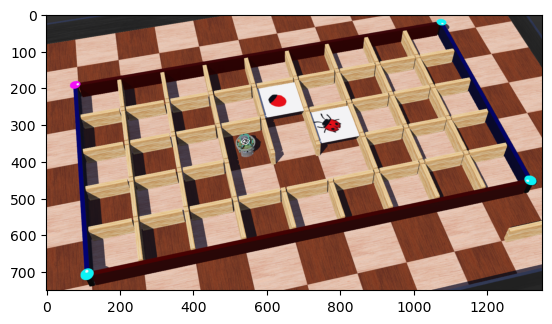

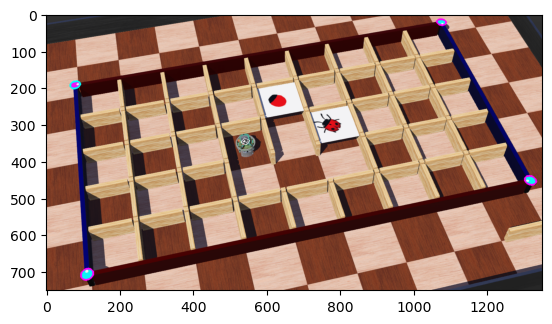

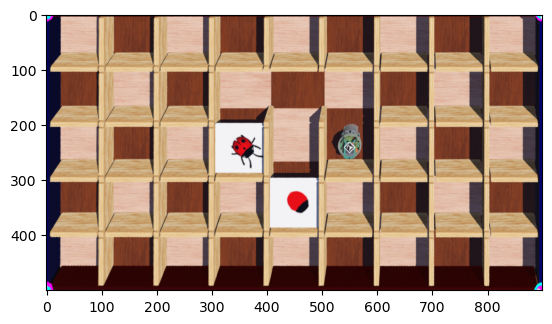

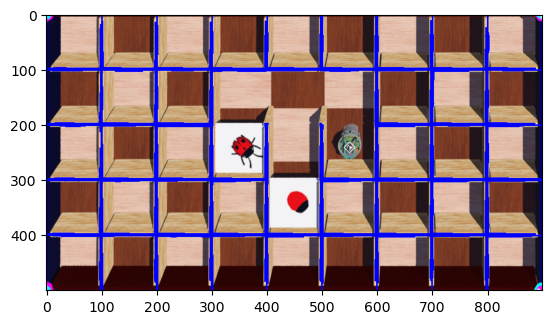

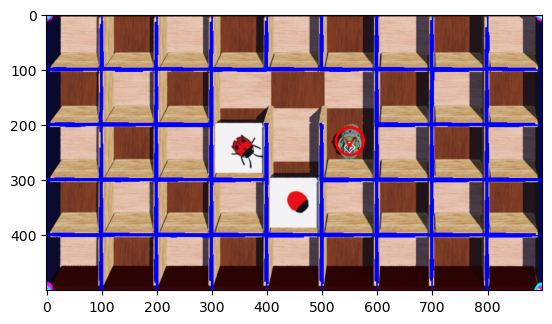

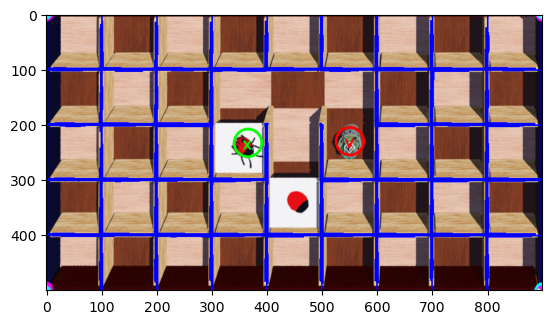

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt #library for plotting

MAZE_FILE_NAME = '../Maze_6.png'
ROBOT_FILE_NAME = '../Robot_6.png'
IMAGE_LADYBUG_FILE_NAME = '../Ladybug_small.png'



def findCornerStones(img):
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    maskCyan = cv2.inRange(imgRGB, (10, 230, 230), (30, 255, 255)) # produces a mask for cyan object
    kernelCyan = np.ones((7,7), np.uint8)
    dilationCyan = cv2.dilate(maskCyan, kernelCyan, iterations = 3)
    erodingCyan = cv2.erode(dilationCyan, kernelCyan, iterations = 3)
    _, contoursCyan, hierarchy = cv2.findContours(erodingCyan, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #cv2.drawContours(img, contoursCyan, -1, (255, 0, 255), 3)

    maskPink = cv2.inRange(imgRGB, (220, 0, 220), (255, 50, 255))
    kernelPink = np.ones((7,7), np.uint8)
    dilationPink = cv2.dilate(maskPink, kernelPink, iterations = 3)
    erodingPink = cv2.erode(dilationPink, kernelPink, iterations = 3)
    _, contoursPink, hierarchy = cv2.findContours(erodingPink, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    #cv2.drawContours(img, contoursPink, -1, (255, 0, 0), 3)

    src = np.zeros(shape=(4, 2))
    i = 0
    for c in contoursCyan:
        M = cv2.moments(c)
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        src[i] = [cX, cY]
        i = i+1
        cv2.drawContours(imgRGB, [c], -1, (255, 0, 255), 3)

    for c in contoursPink:
        M = cv2.moments(c)
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        src[3] = [cX, cY]
        cv2.drawContours(imgRGB, [c], -1, (0, 255, 255), 3)

    pinkSrc = src[3]
    closestX = -1
    closestY = -1
    for i in range(3):
        if (closestX < 0):
            closestX = i
        elif (abs(src[i][0] - pinkSrc[0]) < abs(src[closestX][0] - pinkSrc[0])):
            closestX = i
        if (closestY < 0):
            closestY = i
        elif (abs(src[i][1] - pinkSrc[1]) < abs(src[closestY][1] - pinkSrc[1])):
            closestY = i

    copySrc = src.copy()
    src[1] = copySrc[closestX]
    src[2] = copySrc[closestY] 
    src[0] = copySrc[abs(closestX + closestY - 3)] 

    return src, imgRGB


def perspectiveTransform(img, src):
    dest = np.float32([[0,0], 
                    [900,0], 
                    [0,500], 
                    [900,500]])
    matrix = cv2.getPerspectiveTransform(src, dest)
    result = cv2.warpPerspective(img, matrix, (900, 500))

    return result

def detectInnerWalls(img):
    imgHSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    maskBlue = cv2.inRange(imgHSV, (0, 80, 230), (30, 100, 240))
    kernel = np.ones((5,5), np.uint8)
    dilation = cv2.dilate(maskBlue, kernel, iterations = 5)
    erosion = cv2.erode(dilation, kernel, iterations = 5)

    maskBlue = cv2.bitwise_and(imgHSV, imgHSV, mask=erosion)
    maskBlue = cv2.cvtColor(maskBlue, cv2.COLOR_HSV2RGB)
    indices = np.where(maskBlue!=[0,0,0])
    img[indices[0], indices[1], :] = [0, 0, 255]

    return img

def detectRobot(img):
    imgHSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    maskBlue = cv2.inRange(imgHSV, (0, 0, 90), (120, 30, 180))
    kernel = np.ones((5,5), np.uint8)
    dilation = cv2.dilate(maskBlue, kernel, iterations = 2)
    erosion = cv2.erode(dilation, kernel, iterations = 1)
    _, contours, hierarchy = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    src = np.zeros(shape=(1, 2))
    for c in contours:
        M = cv2.moments(c)
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        src[0] = [cX, cY]
        area = cv2.contourArea(c)
        if area > 1000:
            robot = (int(src[0][0]), int(src[0][1]))

    cv2.circle(img, robot, 25, (255, 0, 0), 3)
    heading = detectHeading()
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    textsize = cv2.getTextSize(heading, font, 1, 2)[0]
    textX = int((robot[0] - textsize[0]/2))
    textY = int((robot[1] + textsize[1]/2))

    centerText = (textX, textY)
    cv2.putText(img, heading, centerText, font, 1, (255,0,0), 2, cv2.LINE_AA)

    return heading, img

def detectHeading():
    robot = cv2.imread(ROBOT_FILE_NAME)
    arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_50)
    (corners, ids, rejected) = cv2.aruco.detectMarkers(robot, arucoDict)
    horizontal = corners[0][0][0][0] - corners[0][0][2][0]
    vertical = corners[0][0][0][1] - corners[0][0][2][1]
    if abs(horizontal) > abs(vertical):
        if horizontal > 0:
            heading = '<'
        else:
            heading = '>'
    else:
        if vertical > 0:
            heading = 'v'
        else:
            heading = '^'
    return heading

def detectPosition(img):
    img1 = cv2.imread(IMAGE_LADYBUG_FILE_NAME)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  

    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.68*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    avX = 0
    avY = 0
    for i in range(int(dst_pts.size/2)):
        avX = avX + dst_pts[i][0][0]
        avY = avY + dst_pts[i][0][1]
    avX = avX/(dst_pts.size/2)
    avY = avY/(dst_pts.size/2)

    font = cv2.FONT_HERSHEY_SIMPLEX

    textsize = cv2.getTextSize('x', font, 1, 2)[0]
    textX = int((avX - textsize[0]/2))
    textY = int((avY + textsize[1]/2))

    img2 = cv2.cvtColor(img2, cv2.COLOR_HSV2RGB)
    cv2.circle(img2, (int(avX), int(avY)), 25, (0, 255, 0), 3)

    cv2.putText(img2, 'x', (textX, textY), font, 1, (0,255,0), 2, cv2.LINE_AA)

    plt.imshow(img2),plt.show()

def generateMap():
    pass

img = cv2.imread(MAZE_FILE_NAME)
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#PART 1
plt.imshow(imgRGB)
plt.show()

#PART 2
src, imgRGBContour = findCornerStones(img)
plt.imshow(imgRGBContour)
plt.show()
srcFloat = np.float32([list(src[0]),list(src[1]),list(src[2]),list(src[3])])

#PART 3
MAZE_PERSPECTIVE_TRANSFORM = perspectiveTransform(imgRGBContour, srcFloat)
plt.imshow(MAZE_PERSPECTIVE_TRANSFORM)
plt.show()

#PART 4
imgWalls = detectInnerWalls(MAZE_PERSPECTIVE_TRANSFORM)
plt.imshow(imgWalls)
plt.show()

# PART 5
heading, imgHeading = detectRobot(imgWalls)
plt.imshow(imgHeading)
plt.show()

# PART 6
imgPosition = detectPosition(imgHeading)

#PART 7

